<a href="https://colab.research.google.com/github/Alex86Mart/Alex86Mart/blob/main/PROJECT_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение комплескной бизнес-задачи по подготовке основы для рекомендательной системе

## Описание задачи

**ЦЕЛЬ**  
Подготовить основу рекомендательной системы.

**ЗАДАЧИ**  
Создать рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.
Изначальным воплощением этой системы может стать таблица, в которой курсам будет соответствовать по две рекомендации.

**КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)**  
* Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
* Обработать данные средствами Python.
* Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
* Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

**РЕЗУЛЬТАТ ПРОЕКТА**  
Итогом работы станет файл, содержащий результаты всех промежуточных этапов: скрипты с комментариями, таблица рекомендаций и выводы.

## Знакомство с данными

In [ ]:
import itertools
import collections
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns


warnings.filterwarnings('ignore')
%matplotlib inline

В распоряжении две таблицы:

`carts` с данными о пользовательских корзинах (дате создания, статусе, id пользователя-владельца и т. д.);  
`cart items` с данными о курсах, которые пользователи добавили в корзину.

55.3.1 Продажи за какие годы есть в ваших данных?

In [ ]:
'''
SELECT DISTINCT (extract(YEAR
                         FROM purchased_at))
FROM final.carts
WHERE state='successful';

2018
2017
'''

55.3.2 Сколько клиентов покупали курсы?

In [ ]:
'''
SELECT count(DISTINCT user_id)
FROM final.carts AS c
LEFT JOIN final.cart_items AS ci ON c.id=ci.cart_id
WHERE ci.resource_type='Course'
  AND c.state='successful';

49006
'''

55.3.3 Сколько всего есть различных курсов?

In [ ]:
'''
SELECT count(DISTINCT resource_id)
FROM final.cart_items
WHERE resource_type='Course';

127
'''

55.3.4 Каково среднее число купленных курсов на одного клиента?

In [ ]:
'''
SELECT round(avg(cnt_course), 2)
FROM
  (SELECT count(ci.resource_id) AS cnt_course
   FROM final.carts AS c
   LEFT JOIN final.cart_items AS ci ON c.id=ci.cart_id
   WHERE ci.resource_type='Course'
     AND c.state='successful'
   GROUP BY user_id) AS cnt_tab;

1.44
'''

55.3.5 Сколько клиентов купили больше одного курса?

In [ ]:
'''
SELECT count(user_id)
FROM
  (SELECT user_id,
          count(DISTINCT ci.resource_id)
   FROM final.carts AS c
   LEFT JOIN final.cart_items AS ci ON c.id=ci.cart_id
   WHERE ci.resource_type='Course'
     AND c.state='successful'
   GROUP BY user_id
   HAVING count(DISTINCT ci.resource_id)>1) AS tmp_tab;

12656
'''

55.3.6 Сколько различных пар курсов встречаются вместе в покупках клиентов?

Подготовим таблицу с данными по продажам курсов в разрезе пользователей купивших более одного курса.

In [ ]:
query = '''
WITH interested_clients AS
  (SELECT user_id,
          COUNT (DISTINCT resource_id) AS quantity
   FROM final.carts c
   JOIN final.cart_items i ON i.cart_id = c.id
   WHERE state = 'successful'
     AND resource_type = 'Course'
   GROUP BY 1
   HAVING COUNT (DISTINCT resource_id) > 1)

SELECT distinct c.user_id,
       i.resource_id
FROM final.carts c
JOIN final.cart_items i ON i.cart_id = c.id
JOIN interested_clients ic ON ic.user_id = c.user_id
WHERE state = 'successful'
     AND resource_type = 'Course'
ORDER BY 1
'''

In [ ]:
try:
    connection = psycopg2.connect(
        user="skillfactory",
        password="cCkxxLVrDE8EbvjueeMedPKt",
        host="84.201.134.129",
        port="5432",
        database="skillfactory",
    )
    cursor = connection.cursor()

    cursor.execute(query)
    df = cursor.fetchall()
    connection.commit()

except (Exception, psycopg2.Error) as error:
    if connection:
        print("Error", error)
finally:
    if connection:
        cursor.close()
        connection.close()

In [ ]:
df = pd.DataFrame(df, columns=['user_id', 'resource_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      34074 non-null  int64
 1   resource_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [ ]:
df

,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125
...,...,...
34069,2188926,515
34070,2188926,743
34071,2190141,756
34072,2190141,794


Сгруппируем пользователей таким образом, чтобы каждому пользователю соответствовал список из id курсов, которые он приобрел.

In [ ]:
df_together_courses = df.groupby('user_id')['resource_id'].unique().reset_index()
df_together_courses

,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


Отсортируем курсы по возрастанию номера id для каждого пользователя

In [ ]:
df_together_courses['resource_id'] = df_together_courses['resource_id'].apply(lambda x: sorted(x))
df_together_courses

,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


Разобьем списки курсов на возможные пары курсов и подсчитаем количество полученных уникальных пар

In [ ]:
courses_list = []
for courses in df_together_courses['resource_id']:
    for course_pair in itertools.combinations(courses, 2):
        courses_list.append(course_pair)

In [ ]:
len(set(courses_list))

3989

55.3.7 Найдите самую популярную пару курсов. Какие у них ID?

In [ ]:
from collections import Counter
cntr_crs_pair = Counter(courses_list)
cntr_crs_pair = {k: cntr_crs_pair[k] for k in sorted(cntr_crs_pair,  key=cntr_crs_pair.get, reverse=True)}
cntr_crs_pair

In [ ]:
Counter(courses_list).most_common(1)[0][0]

(551, 566)

Самая популярная пара курсов с ID 551 и 556, всего данная пара встречалась у 797 пользователей

## Финальный шаг. Составление отчета

Оформим таблицу с рекомендациями для продакт-менеджера и отдела маркетинга.

Составим таблицу с тремя столбцами:

 - Столбец 1. Курс, к которому идёт рекомендация
 - Столбец 2. Курс для рекомендации № 1 (самый популярный)
 - Столбец 3. Курс для рекомендации № 2 (второй по популярности).

А что делать, если одна из рекомендаций встречается слишком мало раз? В таком случае, во-первых, нужно установить минимальную границу — какое количество считать слишком малым. А во-вторых, вместо такого малопопулярного курса выводите какой-то другой курс, который, на ваш аргументированный взгляд, подходит лучше.

Определим количество уникальных курсов - это будет соответствовать количеству строк в нашей таблице

In [ ]:
len(df['resource_id'].unique())

126

Создадим датафрейм из пар курсов и частотности их совместных покупок

In [ ]:
df_cnt = pd.DataFrame(Counter(courses_list).most_common(), columns=['pairs', 'count'])
df_cnt

,pairs,count
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
3984,"(741, 791)",1
3985,"(361, 1128)",1
3986,"(743, 1156)",1
3987,"(864, 1129)",1


Расклеим пары и запишем в столбец `course` - курс, к которому идет рекомендация, а в столбце `course_rec` - курс для рекомендации. Таким образом, каждую пару необходимо записать два раза - сначала первый курс из пары попадает в столбец `course`, затем в столбец `course_rec`.  
Создадим для первого и второго случая два датафрейма, применим к ним соответствующие преобразования, а затем объединим.

In [ ]:
df_1 = df_cnt.copy()
df_2 = df_cnt.copy()

df_1['course'] = df_1['pairs'].apply(lambda x: x[0])
df_1['course_rec'] = df_1['pairs'].apply(lambda x: x[1])

df_2['course'] = df_2['pairs'].apply(lambda x: x[1])
df_2['course_rec'] = df_2['pairs'].apply(lambda x: x[0])

In [ ]:
df_1, df_2

(            pairs  count  course  course_rec
 0      (551, 566)    797     551         566
 1      (515, 551)    417     515         551
 2      (489, 551)    311     489         551
 3      (523, 551)    304     523         551
 4      (566, 794)    290     566         794
 ...           ...    ...     ...         ...
 3984   (741, 791)      1     741         791
 3985  (361, 1128)      1     361        1128
 3986  (743, 1156)      1     743        1156
 3987  (864, 1129)      1     864        1129
 3988  (756, 1185)      1     756        1185
 
 [3989 rows x 4 columns],
             pairs  count  course  course_rec
 0      (551, 566)    797     566         551
 1      (515, 551)    417     551         515
 2      (489, 551)    311     551         489
 3      (523, 551)    304     551         523
 4      (566, 794)    290     794         566
 ...           ...    ...     ...         ...
 3984   (741, 791)      1     791         741
 3985  (361, 1128)      1    1128         361
 3986 

In [ ]:
df_common = pd.concat([df_1, df_2]).reset_index(drop=True)
df_common

,pairs,count,course,course_rec
0,"(551, 566)",797,551,566
1,"(515, 551)",417,515,551
2,"(489, 551)",311,489,551
3,"(523, 551)",304,523,551
4,"(566, 794)",290,566,794
...,...,...,...,...
7973,"(741, 791)",1,791,741
7974,"(361, 1128)",1,1128,361
7975,"(743, 1156)",1,1156,743
7976,"(864, 1129)",1,1129,864


Для каждого курса из столбца `course` найдем ранг соответствующей ей пары, который будет присваиваться в порядке убывания частотности их совместных покупок, т.е. по столбцу `count`

In [ ]:
df_common['rank'] = df_common.sort_values(by='count', ascending=False).groupby('course').cumcount()+1


Посмотри как выглядит наша таблица для одного конкретного курса

In [ ]:
df_common[df_common['course'] == 551].sort_values('rank')

,pairs,count,course,course_rec,rank
0,"(551, 566)",797,551,566,1
3990,"(515, 551)",417,551,515,2
3991,"(489, 551)",311,551,489,3
3992,"(523, 551)",304,551,523,4
3996,"(490, 551)",247,551,490,5
...,...,...,...,...,...
6918,"(360, 551)",1,551,360,113
3204,"(551, 1182)",1,551,1182,114
3170,"(551, 866)",1,551,866,115
3824,"(551, 830)",1,551,830,116


Каждая пара должна быть представлена в нашей таблице двумя записями

In [ ]:
df_common[df_common['pairs'] == tuple((360, 551))]

,pairs,count,course,course_rec,rank
2929,"(360, 551)",1,360,551,31
6918,"(360, 551)",1,551,360,113


Оставим только записи соответствующие первому и второму рангу, удалим столбец `pairs`

In [ ]:
df_common = df_common[(df_common['rank'] == 1) | (df_common['rank'] == 2)]
df_common.drop('pairs', axis=1, inplace=True)

In [ ]:
df_common[df_common['course'] == 551]

,count,course,course_rec,rank
0,797,551,566,1
3990,417,551,515,2


Каждый курс представлен в таблице двумя записями, соответствующие наиболее популярной с ним паре и второй по популярности. Оставим одну строку для каждого курса, а второй по популярности запишем рядом

In [ ]:
df_rec = df_common[df_common['rank'] == 1].merge(df_common[df_common['rank'] == 2], on='course', how='left', suffixes=('_1', '_2'))

In [ ]:
df_rec[df_rec['course'] == 551]

,count_1,course,course_rec_1,rank_1,count_2,course_rec_2,rank_2
0,797,551,566,1,417,515,2


Переставим столбцы для удобства восприятия

In [ ]:
df_rec = df_rec.reindex(columns=['course', 'course_rec_1', 'count_1', 'rank_1', 'course_rec_2', 'count_2', 'rank_2'])
df_rec

,course,course_rec_1,count_1,rank_1,course_rec_2,count_2,rank_2
0,551,566,797,1,515,417,2
1,515,551,417,1,489,286,2
2,489,551,311,1,515,286,2
3,523,551,304,1,515,213,2
4,490,566,253,1,551,247,2
...,...,...,...,...,...,...,...
121,833,507,2,1,570,2,2
122,1201,571,1,1,1144,1,2
123,1182,553,1,1,1103,1,2
124,902,519,1,1,777,1,2


Устроим небольшую проверку исходя из первой строчки нашей таблицы: первым в списке рекомендации по курсу с ID 551 стоит курс 566 с количеством совместных покупок 797. Значит первым в списке рекомендации курса 566 должен быть курс 551 с таким же количеством покупок.

In [ ]:
df_rec[df_rec['course']==551]

,course,course_rec_1,count_1,rank_1,course_rec_2,count_2,rank_2
0,551,566,797,1,515,417,2


In [ ]:
df_rec[df_rec['course']==566]

,course,course_rec_1,count_1,rank_1,course_rec_2,count_2,rank_2
39,566,551,797,1,794,290,2


In [ ]:
df_rec[df_rec['course']==515]

,course,course_rec_1,count_1,rank_1,course_rec_2,count_2,rank_2
1,515,551,417,1,489,286,2


Посмотрим на распределение курсов в порядке убывания максимальных частотностей совместных покупок с другими курсами.

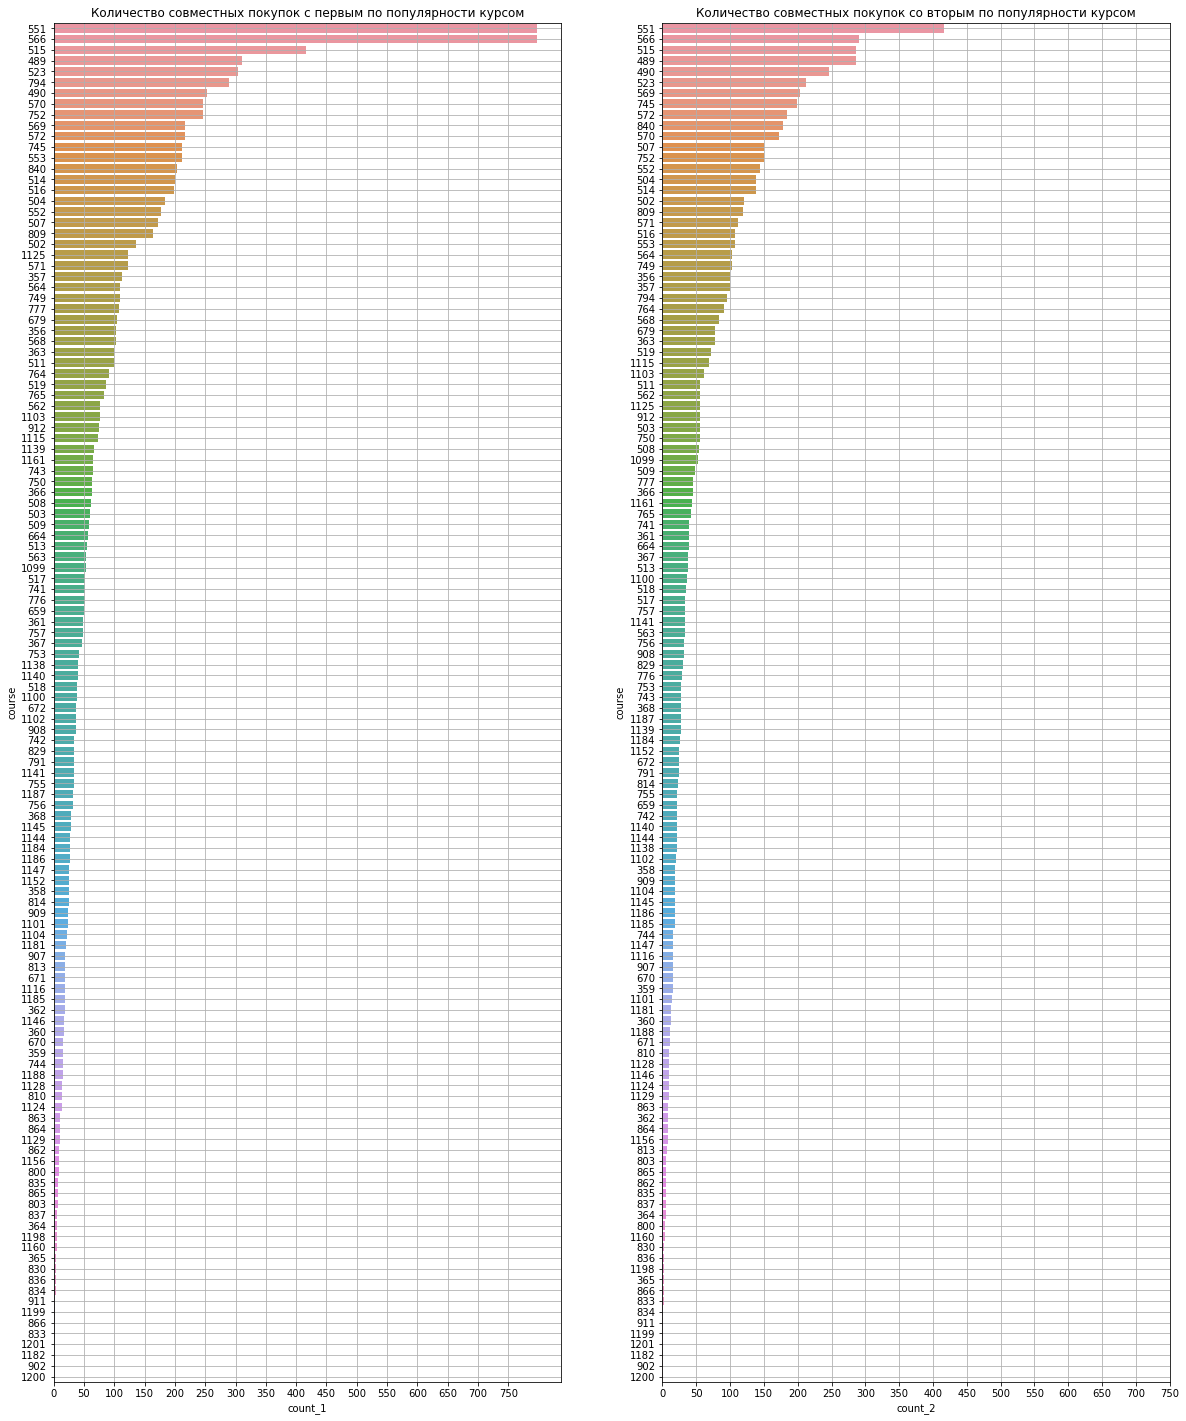

In [ ]:
plt.figure(figsize=(20,25))
plt.subplot(1,2,1)
sns.barplot(data=df_rec, y='course', x='count_1', order=df_rec.sort_values(by='count_1', ascending=False)['course'],  orient='h')
plt.xticks(range(0,800,50))
plt.title('Количество совместных покупок с первым по популярности курсом')
plt.grid()

plt.subplot(1,2,2)
sns.barplot(data=df_rec, y='course', x='count_2', order=df_rec.sort_values(by='count_2', ascending=False)['course'],  orient='h')
plt.title('Количество совместных покупок со вторым по популярности курсом')
plt.xticks(range(0,800,50))
plt.grid()

Наиболее популярными являются курсы 551 и 566, количество совместных покупок по ним достигает максимальных значений в районе 800, следующий по популярности курс 515 уже практически в два раза менее популярен при совместных покупках. Ряд курсов практически не приобретается совместно с какими-либо другими курсами.  
Посмотрим также на боксплот распределения количества совместных покупок `count_1`

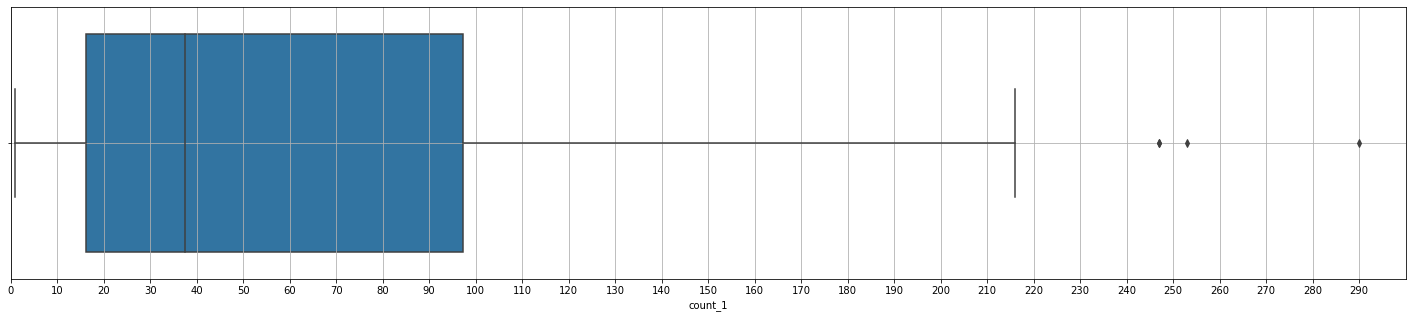

In [ ]:
plt.figure(figsize=(25,5))
sns.boxplot(data=df_rec, x='count_1')
plt.xlim([0,300])
plt.xticks(range(0,300,10))
plt.grid()

In [ ]:
df_common['count'].describe()

count    252.000000
mean      67.515873
std       99.771551
min        1.000000
25%       13.750000
50%       33.500000
75%       78.500000
max      797.000000
Name: count, dtype: float64

В районе нуля достаточно много курсов, явных выбросов в левой части боксплота нет. К первой квартили относятся курсы с максимальным количеством парных покупок менее 14-ти. Возьмем данную границу в качестве минимальной, при значениях менее данного уровня, будем предлагать два наиболее популярных курса из нашей выборки.

In [ ]:
df_rec

,course,course_rec_1,count_1,rank_1,course_rec_2,count_2,rank_2
0,551,566,797,1,515,417,2
1,515,551,417,1,489,286,2
2,489,551,311,1,515,286,2
3,523,551,304,1,515,213,2
4,490,566,253,1,551,247,2
...,...,...,...,...,...,...,...
121,833,507,2,1,570,2,2
122,1201,571,1,1,1144,1,2
123,1182,553,1,1,1103,1,2
124,902,519,1,1,777,1,2


In [ ]:
df_rec.loc[df_rec['count_1'] < 14, 'course_rec_1'] = 551
df_rec.loc[df_rec['count_2'] < 14, 'course_rec_2'] = 566
df_rec

,course,course_rec_1,count_1,rank_1,course_rec_2,count_2,rank_2
0,551,566,797,1,515,417,2
1,515,551,417,1,489,286,2
2,489,551,311,1,515,286,2
3,523,551,304,1,515,213,2
4,490,566,253,1,551,247,2
...,...,...,...,...,...,...,...
121,833,551,2,1,566,2,2
122,1201,551,1,1,566,1,2
123,1182,551,1,1,566,1,2
124,902,551,1,1,566,1,2


Удалим вспомогательные столбцы и приведем таблицу к окончательному виду.

In [ ]:
df_rec.drop(['count_1', 'rank_1', 'count_2', 'rank_2'], axis=1, inplace=True)
df_rec

,course,course_rec_1,course_rec_2
0,551,566,515
1,515,551,489
2,489,551,515
3,523,551,515
4,490,566,551
...,...,...,...
121,833,551,566
122,1201,551,566
123,1182,551,566
124,902,551,566


## Выводы

Исходя из таблиц `carts` с данными о пользовательских корзинах и `cart items` с данными о курсах, добавленных в корзину, подготовлена таблица с необходимыми для решения поставленных задач параметрами. Определены наиболее популярные пары курсов, которые покупаются совместно. Исходя из частотностей совместных покупок сформирована итоговую таблицу с рекомендациями, в которой каждому курсу ставится в соответствие два дополнительных курса для рекомендации к совместному приобретению.